In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2, DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, InputLayer, BatchNormalization, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import *


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_dir = "/kaggle/input/vmmrnew/hj3vvx5946-1/Splited_dataset/train"
test_dir = "/kaggle/input/vmmrnew/hj3vvx5946-1/Splited_dataset/test"
img_width, img_height = 224, 224
batch_size = 32
epochs = 30
num_classes = 48

In [3]:
train_datagen = ImageDataGenerator( rescale=1./255, rotation_range=30, width_shift_range=0.25, 
                                   height_shift_range=0.25, shear_range=0.25, zoom_range=0.25, 
                                   horizontal_flip=True, fill_mode='nearest' )



test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory( train_dir, 
                                                    target_size=(img_width, img_height), 
                                                    batch_size=batch_size, class_mode='categorical', 
                                                    shuffle=True)

test_generator = test_datagen.flow_from_directory( test_dir, 
                                                  target_size=(img_width, img_height), 
                                                  batch_size=batch_size, class_mode='categorical', 
                                                  shuffle=False )

Found 3096 images belonging to 48 classes.
Found 751 images belonging to 48 classes.


In [4]:
def self_attention_block(input_tensor, channels, reduction_ratio=8):
    # Channel-wise attention
    input_channels = input_tensor.shape[-1]
    squeeze = layers.GlobalAveragePooling2D()(input_tensor)
    excitation = layers.Dense(units=input_channels // reduction_ratio, activation='relu')(squeeze)
    excitation = layers.Dense(units=channels, activation='sigmoid')(excitation)
    excitation = layers.Reshape((1, 1, channels))(excitation)
    scaled = layers.Multiply()([input_tensor, excitation])

    # Spatial-wise attention
    spatial_attention = layers.Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(scaled)
    attention = layers.Multiply()([scaled, spatial_attention])

    return attention


In [5]:
from tensorflow.keras.applications import ResNet152V2
base_model = ResNet152V2(weights='imagenet', include_top=False, 
                         input_shape=(img_width, img_height, 3))

234545216/234545216 [==============================] - 10s 0us/step


In [6]:
x = base_model.output

x = self_attention_block(x, 2048)

x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = tf.keras.layers.Dropout(0.2)(x)

x = self_attention_block(x, 1024)

x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = GlobalAveragePooling2D()(x)

x = tf.keras.layers.Reshape((1, 1, 512))(x)

x = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = BatchNormalization()(x)

x = Conv2D(num_classes, (1, 1), padding='same', activation='softmax')(x)

x = GlobalAveragePooling2D()(x)

preds = tf.keras.layers.Reshape((num_classes,))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=preds)


In [7]:
for layer in model.layers:
    layer.trainable = True

In [8]:
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy', metrics=['accuracy','mse'])

checkpoint = ModelCheckpoint('resnet152+SelfAtten_SplitedDataset.h5',
                             monitor='val_accuracy', save_best_only=True, save_best_weights=True, 
                             mode='max', verbose=2)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=5, mode='max', verbose=2)

reduce_learning_rate=ReduceLROnPlateau(monitor="val_accuracy",
                                       factor=0.1, patience=5, verbose=2)

In [9]:
history=model.fit(train_generator, epochs=epochs, validation_data=test_generator, 
                  callbacks= [checkpoint, early_stop, reduce_learning_rate])

Epoch 1/30


2023-12-14 13:13:10.853352: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


97/97 [==============================] - ETA: 0s - loss: 39.2873 - accuracy: 0.0310 - mse: 0.0204
Epoch 1: val_accuracy improved from -inf to 0.01598, saving model to resnet152+SelfAtten_SplitedDataset.h5
97/97 [==============================] - 178s 717ms/step - loss: 39.2873 - accuracy: 0.0310 - mse: 0.0204 - val_loss: 38.8102 - val_accuracy: 0.0160 - val_mse: 0.0204 - lr: 1.0000e-05
Epoch 2/30
97/97 [==============================] - ETA: 0s - loss: 38.2125 - accuracy: 0.0895 - mse: 0.0201
Epoch 2: val_accuracy improved from 0.01598 to 0.03462, saving model to resnet152+SelfAtten_SplitedDataset.h5
97/97 [==============================] - 55s 563ms/step - loss: 38.2125 - accuracy: 0.0895 - mse: 0.0201 - val_loss: 37.9427 - val_accuracy: 0.0346 - val_mse: 0.0204 - lr: 1.0000e-05
Epoch 3/30
97/97 [==============================] - ETA: 0s - loss: 37.0990 - accuracy: 0.1641 - mse: 0.0195
Epoch 3: val_accuracy improved from 0.03462 to 0.06391, saving model to resnet152+SelfAtten_SplitedD

In [10]:
test_result = model.evaluate(test_generator)
#                             steps=test_generator.samples // batch_size)
test_loss = test_result[0]
test_accuracy = test_result[1]
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

24/24 [==============================] - 4s 166ms/step - loss: 20.7855 - accuracy: 0.8948 - mse: 0.0030
Test Loss: 20.78545570373535
Test Accuracy: 0.8948069214820862


In [11]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

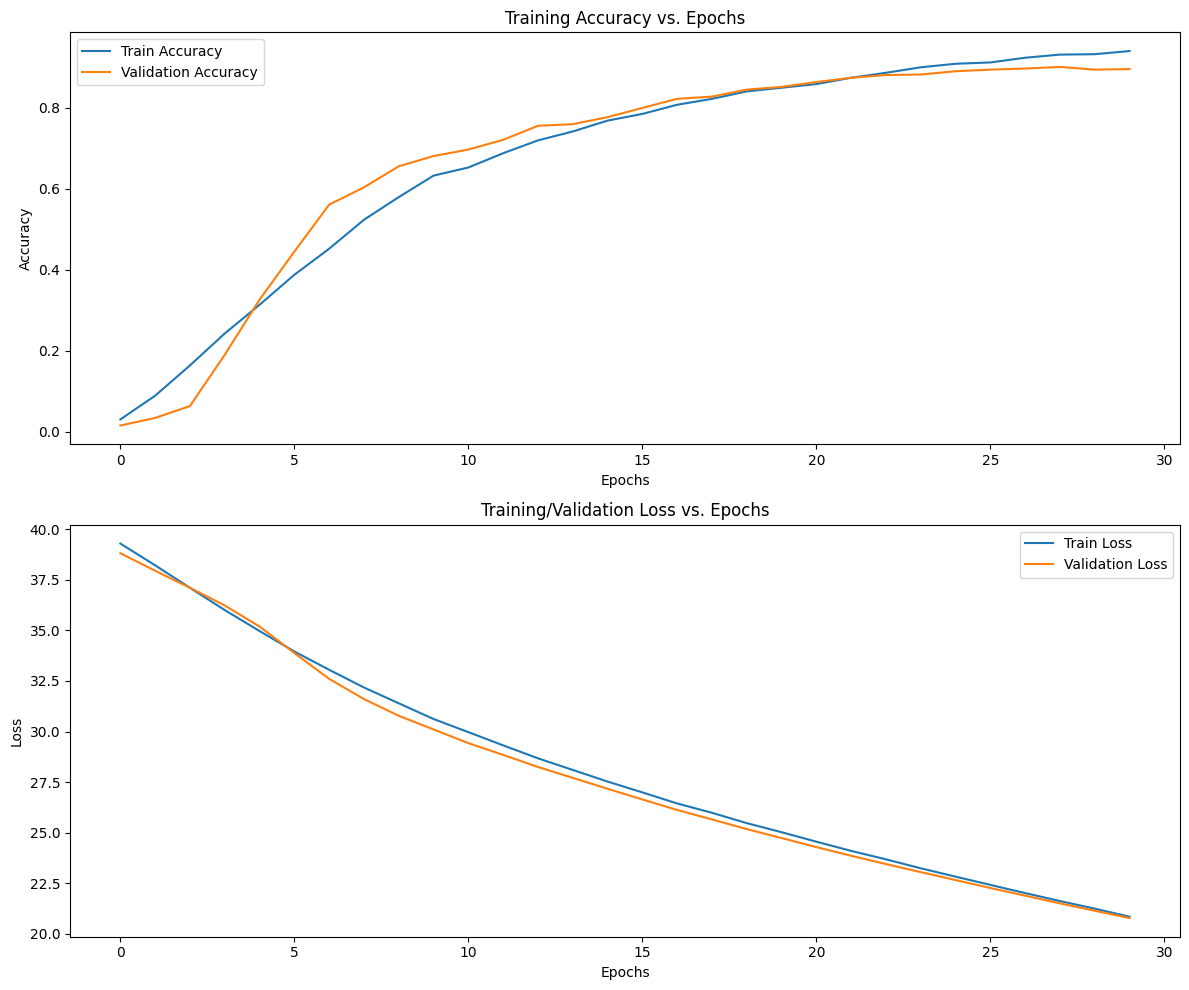

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy,label='Train Accuracy')
ax[0].plot(val_accuracy,label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss,label='Train Loss')
ax[1].plot(val_loss,label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [13]:
train_class_names = sorted(list(train_generator.class_indices.keys()))

test_class_names = sorted(list(test_generator.class_indices.keys()))

assert train_class_names == test_class_names, "Class names in train and test datasets don't match!"

labels = train_class_names

24/24 [==============================] - 7s 165ms/step


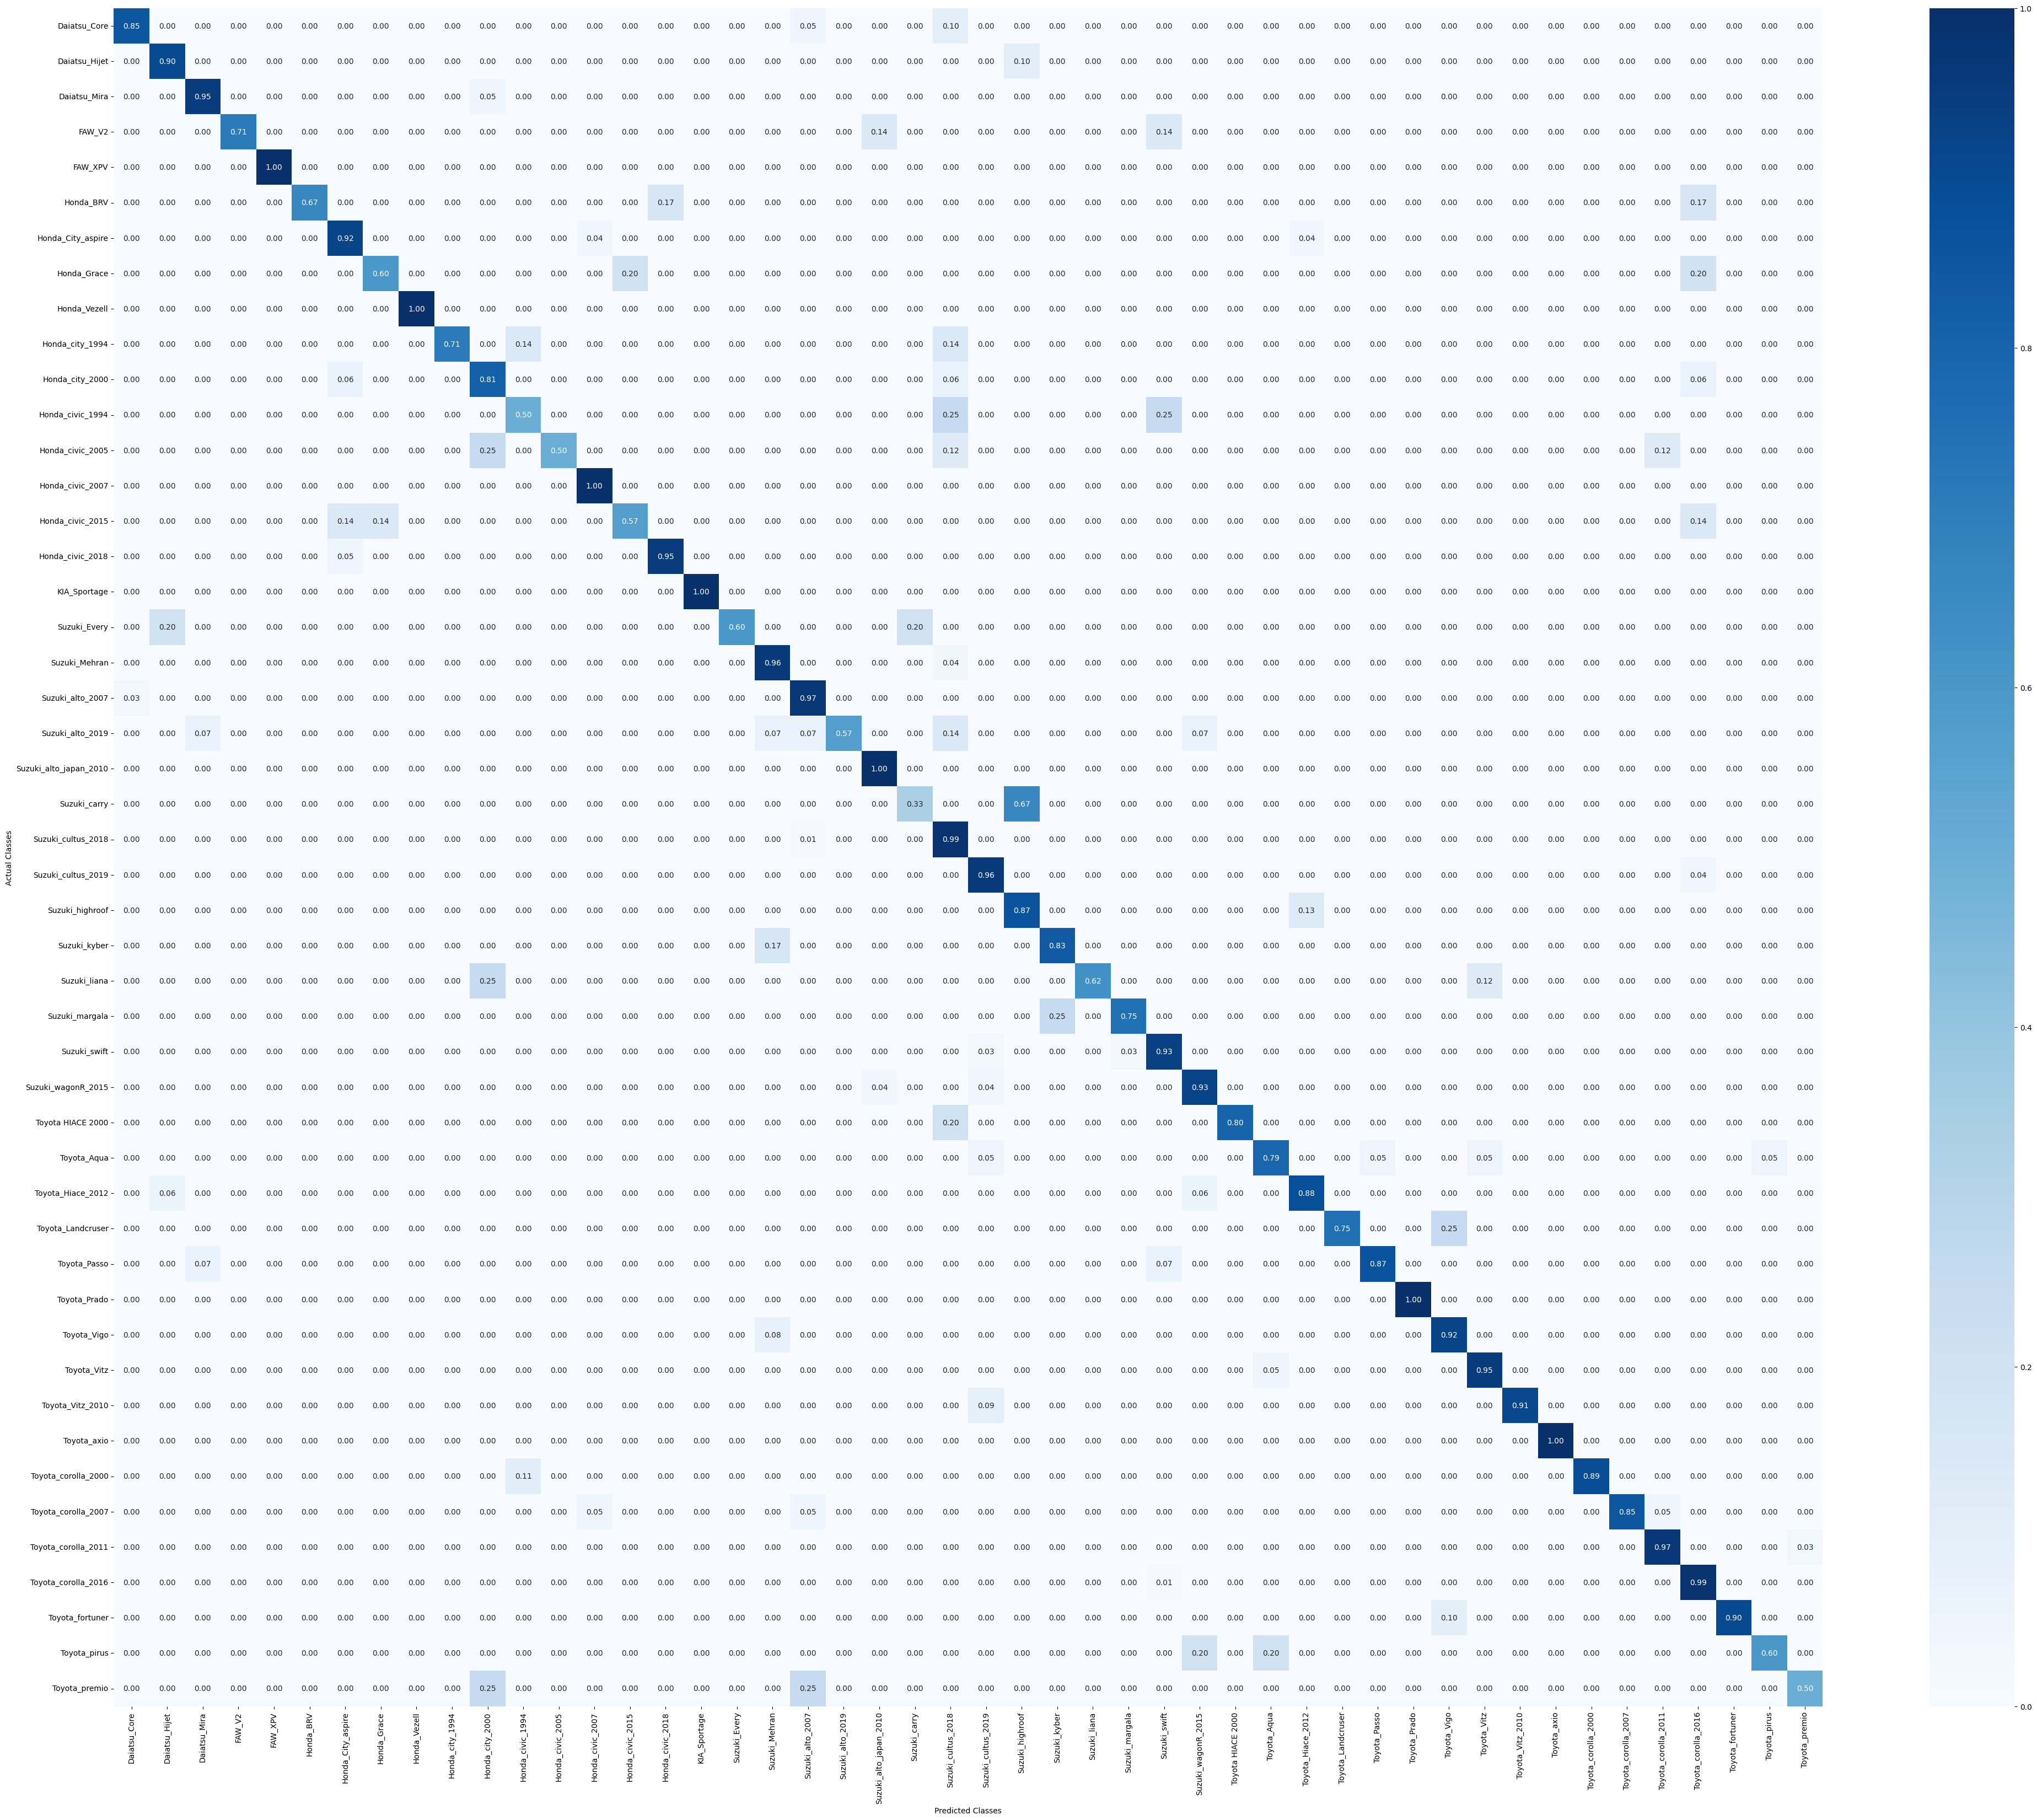

Confusion Matrix:
[[17  0  0 ...  0  0  0]
 [ 0  9  0 ...  0  0  0]
 [ 0  0 19 ...  0  0  0]
 ...
 [ 0  0  0 ...  9  0  0]
 [ 0  0  0 ...  0  3  0]
 [ 0  0  0 ...  0  0  2]]


In [14]:


# Assuming you have the ground truth labels for the test data in a variable called 'true_labels'
true_labels = test_generator.classes

# Generate predictions for the test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Define class labels (replace with your actual class names)
labels = train_class_names  # Replace with your class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
fig, ax = plt.subplots(figsize=(50, 40))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap=plt.cm.Blues)
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')

output_file = 'ConfusionMatrix_resnet_miobd_SelfAtt.png'  
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

# Generate the classification report
report = classification_report(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)


In [15]:
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.82      0.90      0.86        10
           2       0.90      0.95      0.93        20
           3       1.00      0.71      0.83         7
           4       1.00      1.00      1.00         6
           5       1.00      0.67      0.80         6
           6       0.89      0.92      0.91        26
           7       0.75      0.60      0.67         5
           8       1.00      1.00      1.00         9
           9       1.00      0.71      0.83         7
          10       0.68      0.81      0.74        16
          11       0.50      0.50      0.50         4
          12       1.00      0.50      0.67         8
          13       0.90      1.00      0.95        18
          14       0.80      0.57      0.67         7
          15       0.95      0.95      0.95        20
          16       1.00      1.00      1.00         6
    

In [16]:
from keras.models import load_model
model.save('ResNet152V2+SelfAtten_miobd.h5')

import IPython
IPython.display.FileLink("ResNet152V2+SelfAtten_miobd.h5")

/kaggle/working/ResNet152V2+SelfAtten_miobd.h5

In [19]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, 
                         input_shape=(img_width, img_height, 3))

9406464/9406464 [==============================] - 1s 0us/step


In [20]:
x = base_model.output

x = self_attention_block(x, 1280)

x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = tf.keras.layers.Dropout(0.2)(x)

x = self_attention_block(x, 1024)

x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = GlobalAveragePooling2D()(x)

x = tf.keras.layers.Reshape((1, 1, 512))(x)

x = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = BatchNormalization()(x)

x = Conv2D(num_classes, (1, 1), padding='same', activation='softmax')(x)

x = GlobalAveragePooling2D()(x)

preds = tf.keras.layers.Reshape((num_classes,))(x)

model2 = tf.keras.Model(inputs=base_model.input, outputs=preds)


In [21]:
for layer in model2.layers:
    layer.trainable = True

In [23]:
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy','mse'])

checkpoint = ModelCheckpoint('DenseNet201+SelfAtten_miobd.h5',
                             monitor='val_accuracy', save_best_only=True, save_best_weights=True, 
                             mode='max', verbose=2)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=5, mode='max', verbose=2)

reduce_learning_rate=ReduceLROnPlateau(monitor="val_accuracy",
                                       factor=0.1, patience=5, verbose=2)

In [24]:
history1=model2.fit(train_generator, epochs=epochs, validation_data=test_generator, 
                  callbacks= [checkpoint, early_stop, reduce_learning_rate])

Epoch 1/30


2023-12-14 13:59:38.763021: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


97/97 [==============================] - ETA: 0s - loss: 14.5966 - accuracy: 0.1789 - mse: 0.0188
Epoch 1: val_accuracy improved from -inf to 0.03728, saving model to DenseNet201+SelfAtten_miobd.h5
97/97 [==============================] - 89s 557ms/step - loss: 14.5966 - accuracy: 0.1789 - mse: 0.0188 - val_loss: 5.5460 - val_accuracy: 0.0373 - val_mse: 0.0203 - lr: 0.0010
Epoch 2/30
97/97 [==============================] - ETA: 0s - loss: 3.2663 - accuracy: 0.3194 - mse: 0.0165
Epoch 2: val_accuracy did not improve from 0.03728
97/97 [==============================] - 49s 507ms/step - loss: 3.2663 - accuracy: 0.3194 - mse: 0.0165 - val_loss: 4.1156 - val_accuracy: 0.0373 - val_mse: 0.0203 - lr: 0.0010
Epoch 3/30
97/97 [==============================] - ETA: 0s - loss: 2.4831 - accuracy: 0.3769 - mse: 0.0155
Epoch 3: val_accuracy improved from 0.03728 to 0.05326, saving model to DenseNet201+SelfAtten_miobd.h5
97/97 [==============================] - 49s 508ms/step - loss: 2.4831 - accu

In [25]:
test_result2 = model2.evaluate(test_generator)
#                             steps=test_generator.samples // batch_size)
test_loss2 = test_result2[0]
test_accuracy2 = test_result2[1]
print('Test Loss:', test_loss2)
print('Test Accuracy:', test_accuracy2)

24/24 [==============================] - 4s 159ms/step - loss: 8.3029 - accuracy: 0.1531 - mse: 0.0292
Test Loss: 8.30291748046875
Test Accuracy: 0.15312916040420532


In [26]:
from keras.models import load_model
model2.save('BaseMobileNetV2_vmmr.h5')

import IPython
IPython.display.FileLink('BaseDenseNet201_vmmr.h5')

/kaggle/working/BaseDenseNet201_vmmr.h5

In [27]:
train_accuracy2 = history1.history['accuracy']
val_accuracy2 = history1.history['val_accuracy']

train_loss2 = history1.history['loss']
val_loss2 = history1.history['val_loss']

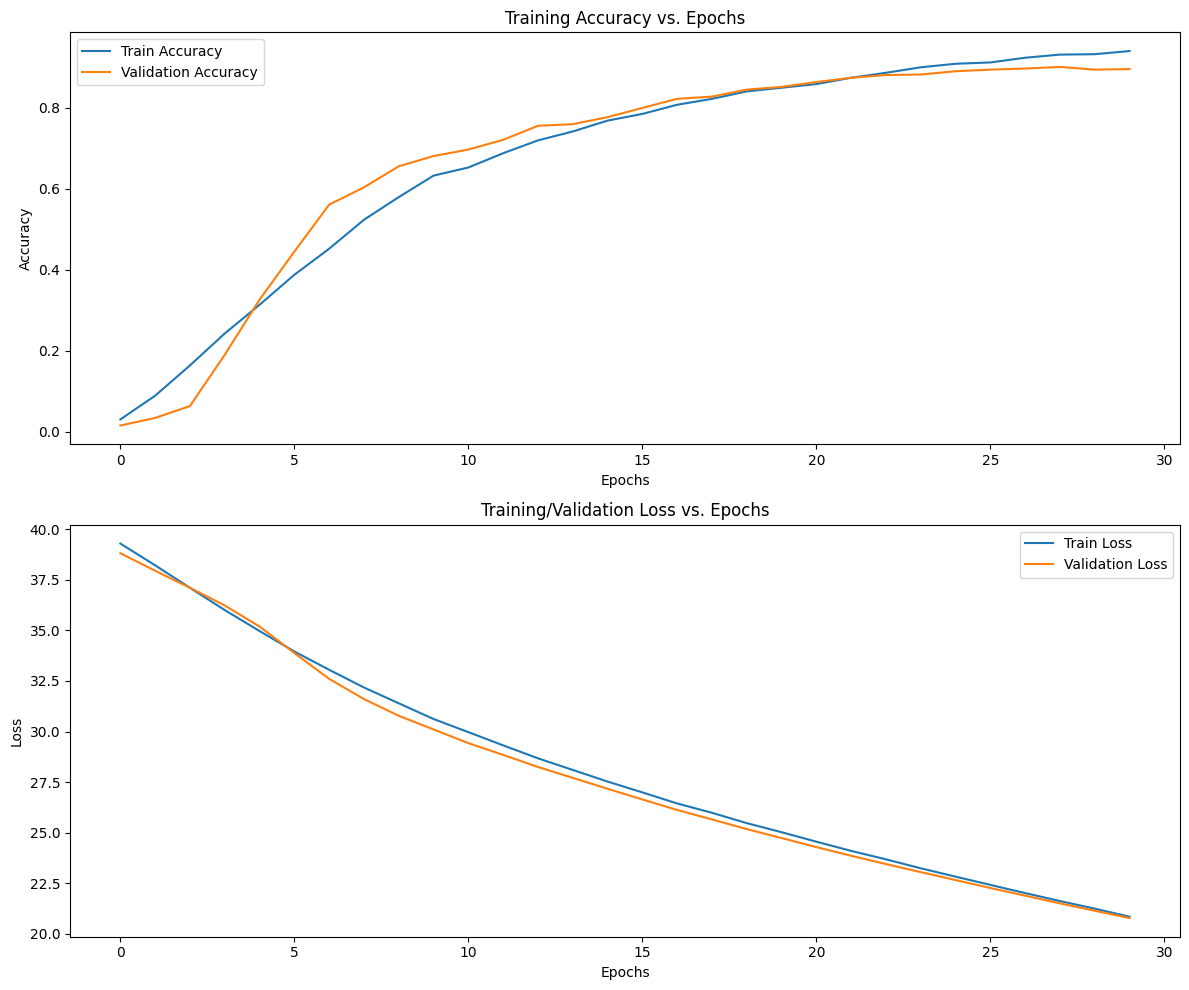

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy,label='Train Accuracy')
ax[0].plot(val_accuracy,label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss,label='Train Loss')
ax[1].plot(val_loss,label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [29]:
train_class_names = sorted(list(train_generator.class_indices.keys()))

test_class_names = sorted(list(test_generator.class_indices.keys()))

assert train_class_names == test_class_names, "Class names in train and test datasets don't match!"

labels = train_class_names

24/24 [==============================] - 4s 159ms/step


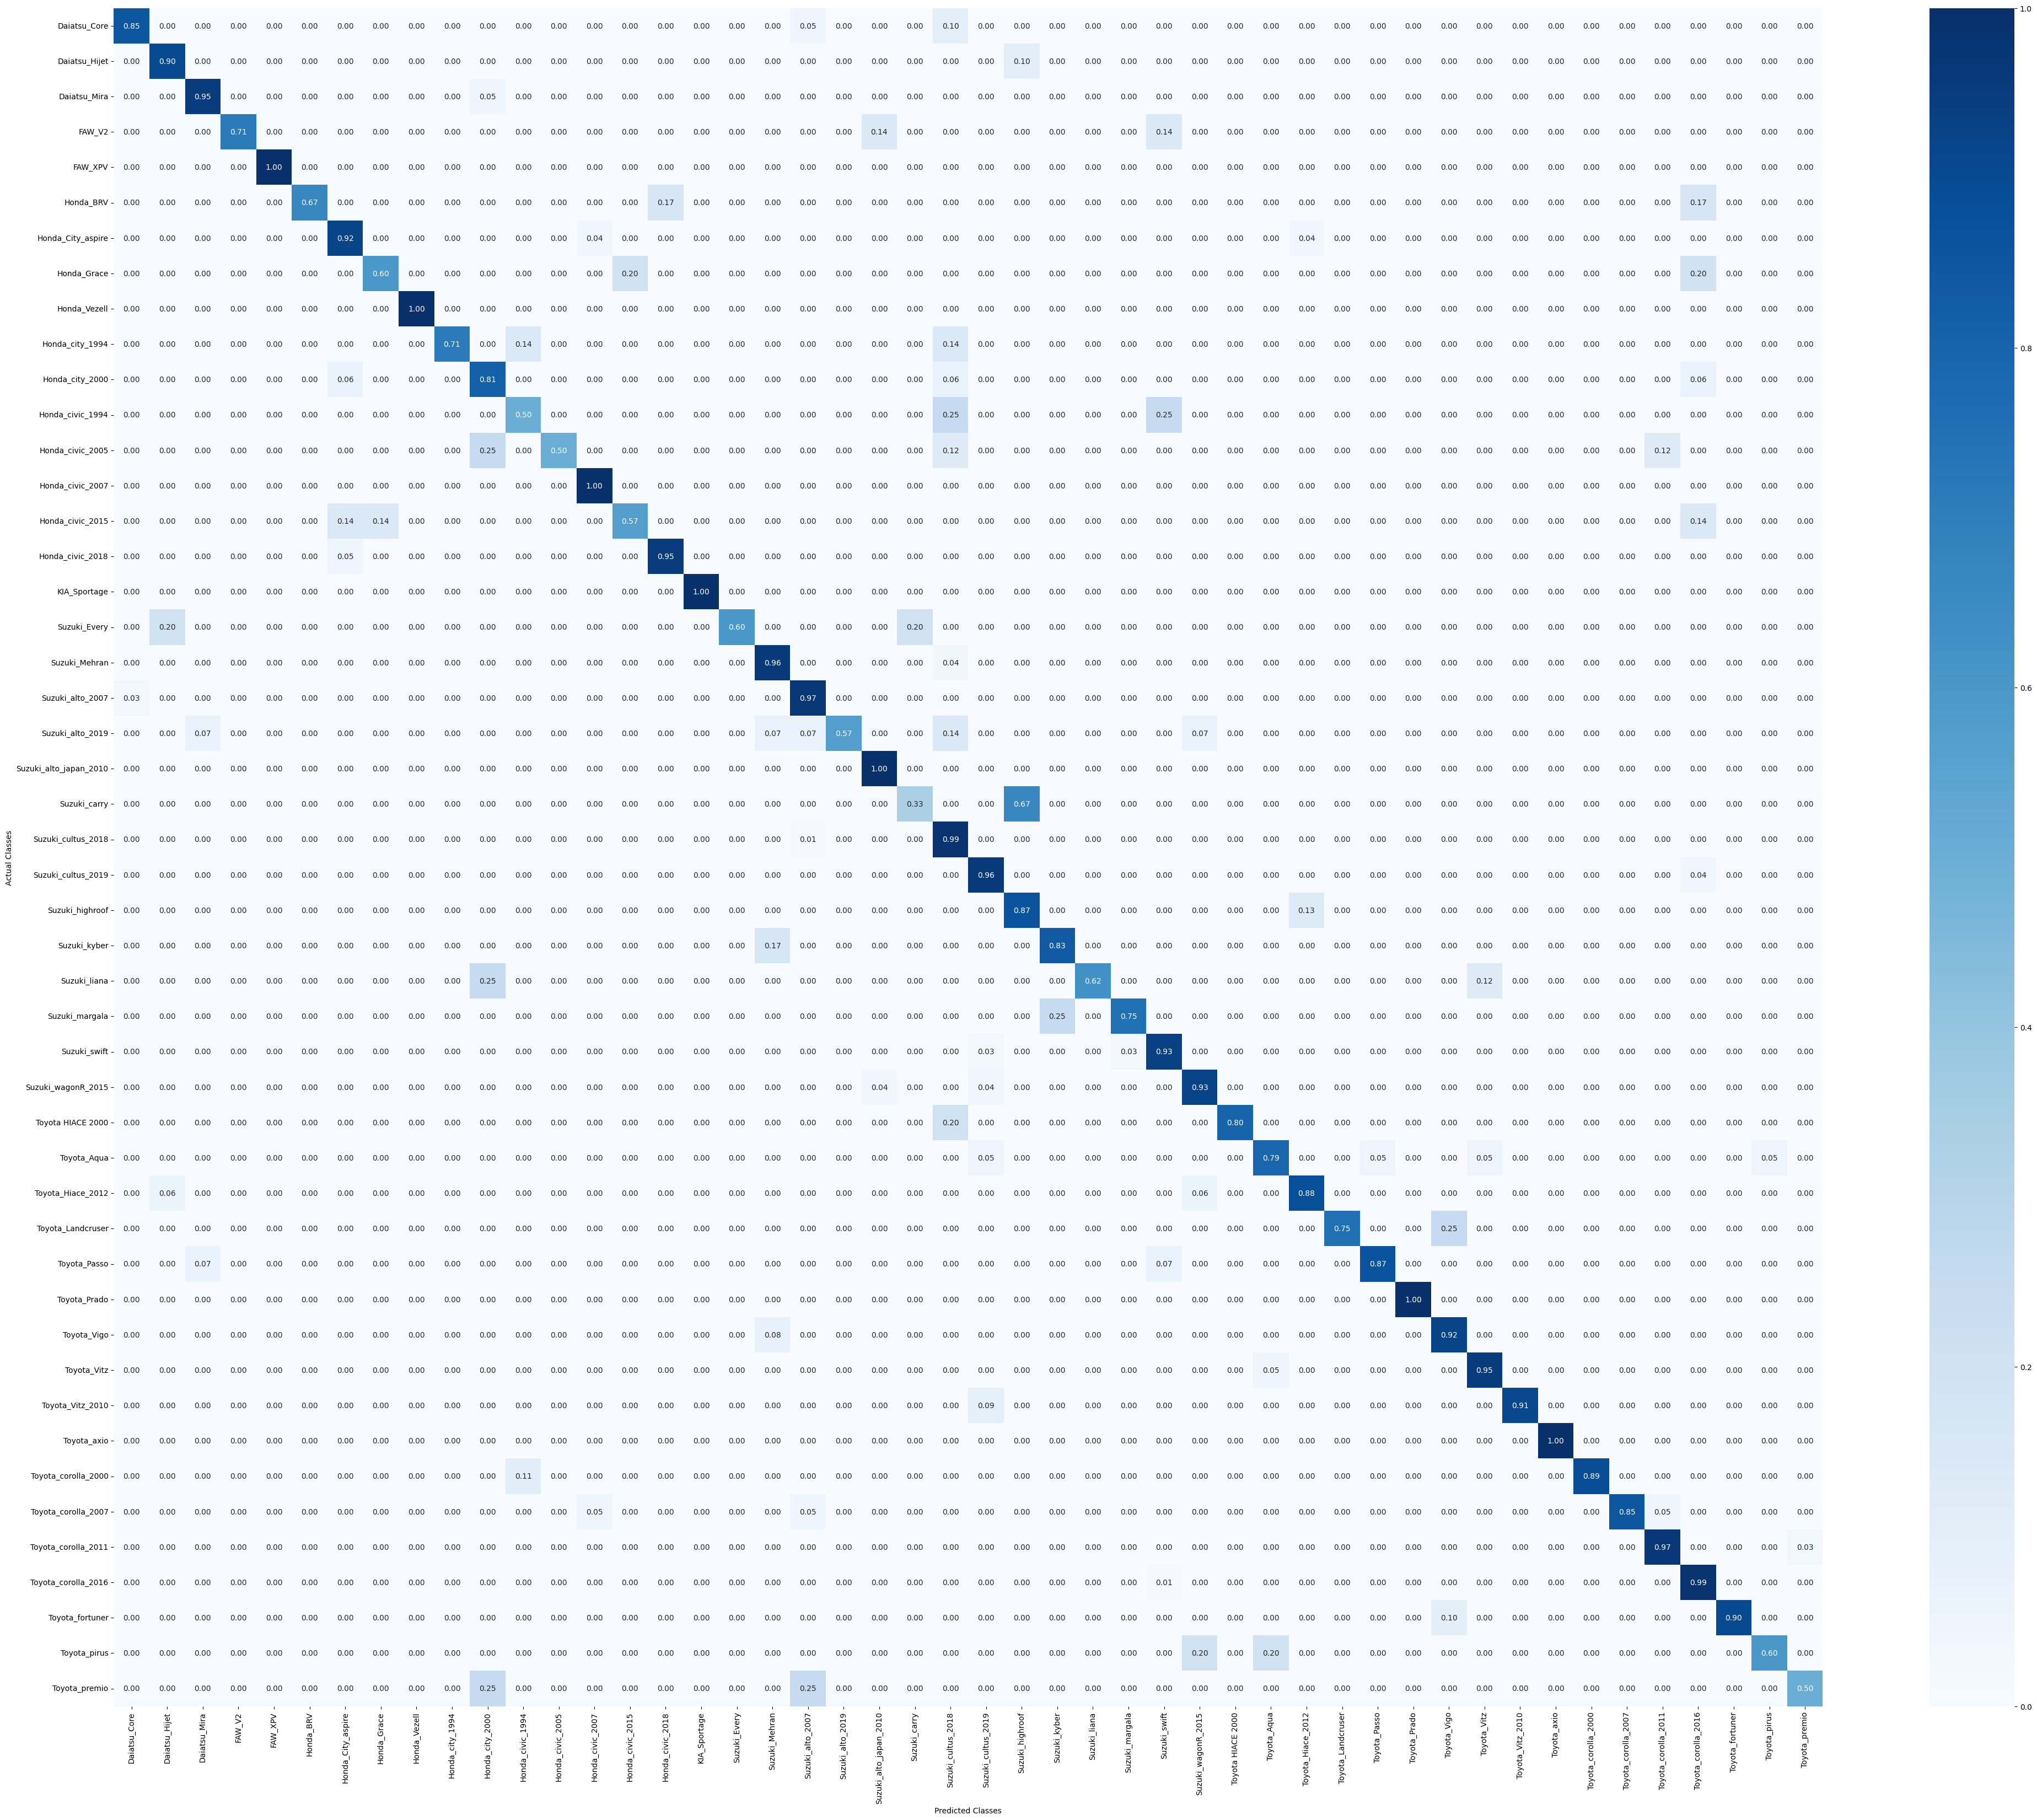

Confusion Matrix:
[[17  0  0 ...  0  0  0]
 [ 0  9  0 ...  0  0  0]
 [ 0  0 19 ...  0  0  0]
 ...
 [ 0  0  0 ...  9  0  0]
 [ 0  0  0 ...  0  3  0]
 [ 0  0  0 ...  0  0  2]]


In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have the ground truth labels for the test data in a variable called 'true_labels'
true_labels = test_generator.classes

# Generate predictions for the test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Define class labels (replace with your actual class names)
labels = train_class_names  # Replace with your class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
fig, ax = plt.subplots(figsize=(50, 40))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap=plt.cm.Blues)
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
output_file = 'ConfusionMatrix_mobilenet_miobd_SelfAtt.png'  
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()


# Generate the classification report
report = classification_report(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)


In [31]:
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.82      0.90      0.86        10
           2       0.90      0.95      0.93        20
           3       1.00      0.71      0.83         7
           4       1.00      1.00      1.00         6
           5       1.00      0.67      0.80         6
           6       0.89      0.92      0.91        26
           7       0.75      0.60      0.67         5
           8       1.00      1.00      1.00         9
           9       1.00      0.71      0.83         7
          10       0.68      0.81      0.74        16
          11       0.50      0.50      0.50         4
          12       1.00      0.50      0.67         8
          13       0.90      1.00      0.95        18
          14       0.80      0.57      0.67         7
          15       0.95      0.95      0.95        20
          16       1.00      1.00      1.00         6
    

In [32]:
from keras.models import load_model
model2.save('BaseMobileNetV2_vmmr.h5')

import IPython
IPython.display.FileLink("BaseDenseNet201_vmmr.h5")

/kaggle/working/BaseDenseNet201_vmmr.h5

In [33]:
from tensorflow.keras.applications import InceptionResNetV2
base_model = InceptionResNetV2(weights='imagenet', include_top=False, 
                         input_shape=(img_width, img_height, 3))

219055592/219055592 [==============================] - 9s 0us/step


In [34]:
x = base_model.output

x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = GlobalAveragePooling2D()(x)

x = tf.keras.layers.Reshape((1, 1, 512))(x)

x = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = BatchNormalization()(x)

x = Conv2D(num_classes, (1, 1), padding='same', activation='softmax')(x)

x = GlobalAveragePooling2D()(x)

preds = tf.keras.layers.Reshape((num_classes,))(x)

model3 = tf.keras.Model(inputs=base_model.input, outputs=preds)


In [36]:
for layer in model3.layers:
    layer.trainable = True

In [37]:
model3.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy', metrics=['accuracy','mse'])

checkpoint = ModelCheckpoint('Xception+SelfAtten_miobd.h5',
                             monitor='val_accuracy', save_best_only=True, save_best_weights=True, 
                             mode='max', verbose=2)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=5, mode='max', verbose=2)

reduce_learning_rate=ReduceLROnPlateau(monitor="val_accuracy",
                                       factor=0.1, patience=5, verbose=2)

In [38]:
history3=model3.fit(train_generator, epochs=epochs, validation_data=test_generator, 
                  callbacks= [checkpoint, early_stop, reduce_learning_rate])

Epoch 1/30


2023-12-14 14:18:32.709546: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


97/97 [==============================] - ETA: 0s - loss: 28.2046 - accuracy: 0.0501 - mse: 0.0209
Epoch 1: val_accuracy improved from -inf to 0.02130, saving model to Xception+SelfAtten_miobd.h5
97/97 [==============================] - 161s 644ms/step - loss: 28.2046 - accuracy: 0.0501 - mse: 0.0209 - val_loss: 27.6205 - val_accuracy: 0.0213 - val_mse: 0.0204 - lr: 1.0000e-05
Epoch 2/30
97/97 [==============================] - ETA: 0s - loss: 27.2681 - accuracy: 0.1179 - mse: 0.0200
Epoch 2: val_accuracy improved from 0.02130 to 0.02663, saving model to Xception+SelfAtten_miobd.h5
97/97 [==============================] - 54s 553ms/step - loss: 27.2681 - accuracy: 0.1179 - mse: 0.0200 - val_loss: 27.1364 - val_accuracy: 0.0266 - val_mse: 0.0204 - lr: 1.0000e-05
Epoch 3/30
97/97 [==============================] - ETA: 0s - loss: 26.4718 - accuracy: 0.1854 - mse: 0.0190
Epoch 3: val_accuracy improved from 0.02663 to 0.07190, saving model to Xception+SelfAtten_miobd.h5
97/97 [=============

In [39]:
test_result = model3.evaluate(test_generator)
#                             steps=test_generator.samples // batch_size)
test_loss = test_result[0]
test_accuracy = test_result[1]
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

24/24 [==============================] - 4s 171ms/step - loss: 16.4037 - accuracy: 0.8775 - mse: 0.0040
Test Loss: 16.403736114501953
Test Accuracy: 0.8774966597557068


In [40]:
train_accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy']

train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

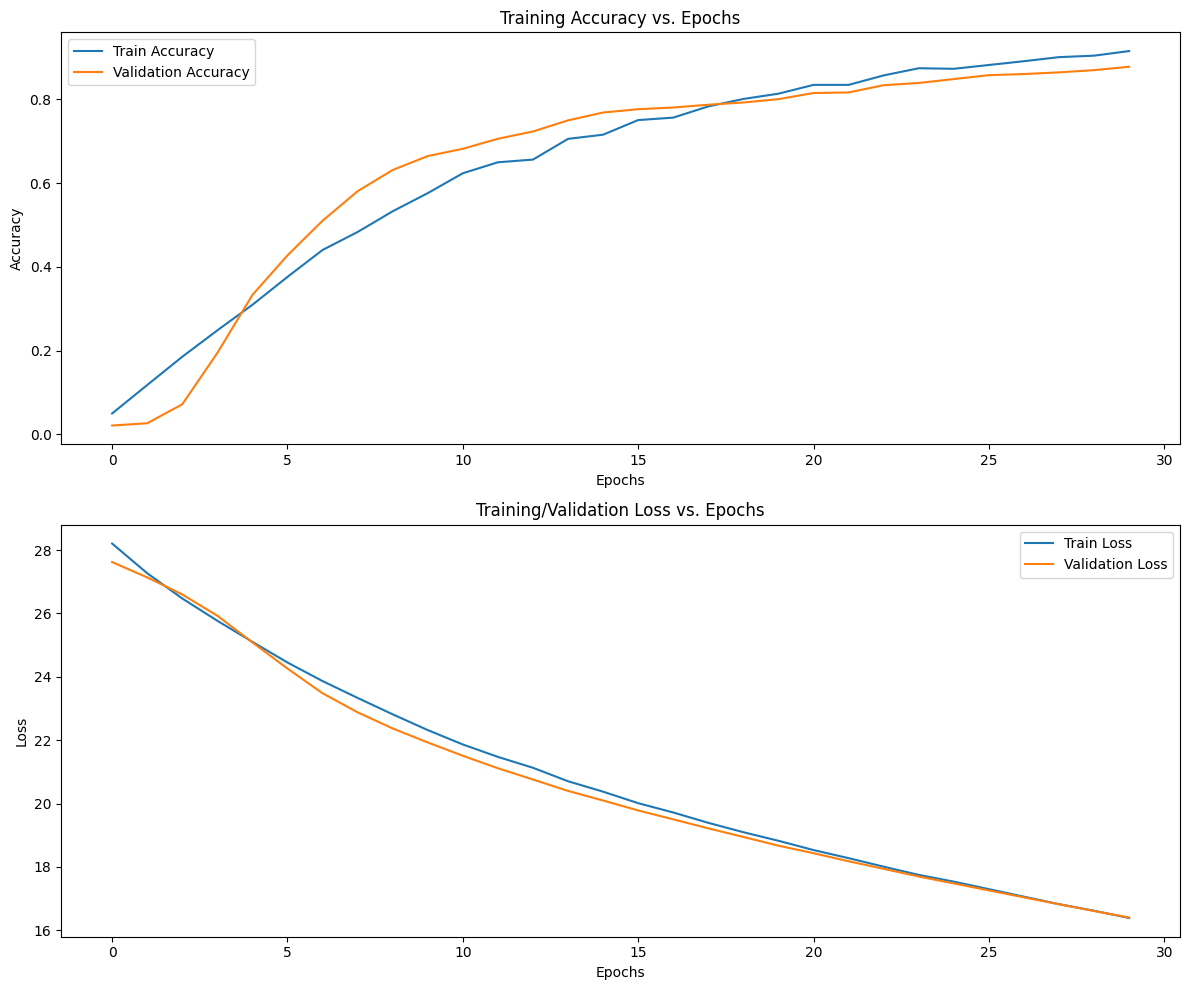

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy,label='Train Accuracy')
ax[0].plot(val_accuracy,label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss,label='Train Loss')
ax[1].plot(val_loss,label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [42]:
train_class_names = sorted(list(train_generator.class_indices.keys()))

test_class_names = sorted(list(test_generator.class_indices.keys()))

assert train_class_names == test_class_names, "Class names in train and test datasets don't match!"

labels = train_class_names

24/24 [==============================] - 4s 173ms/step


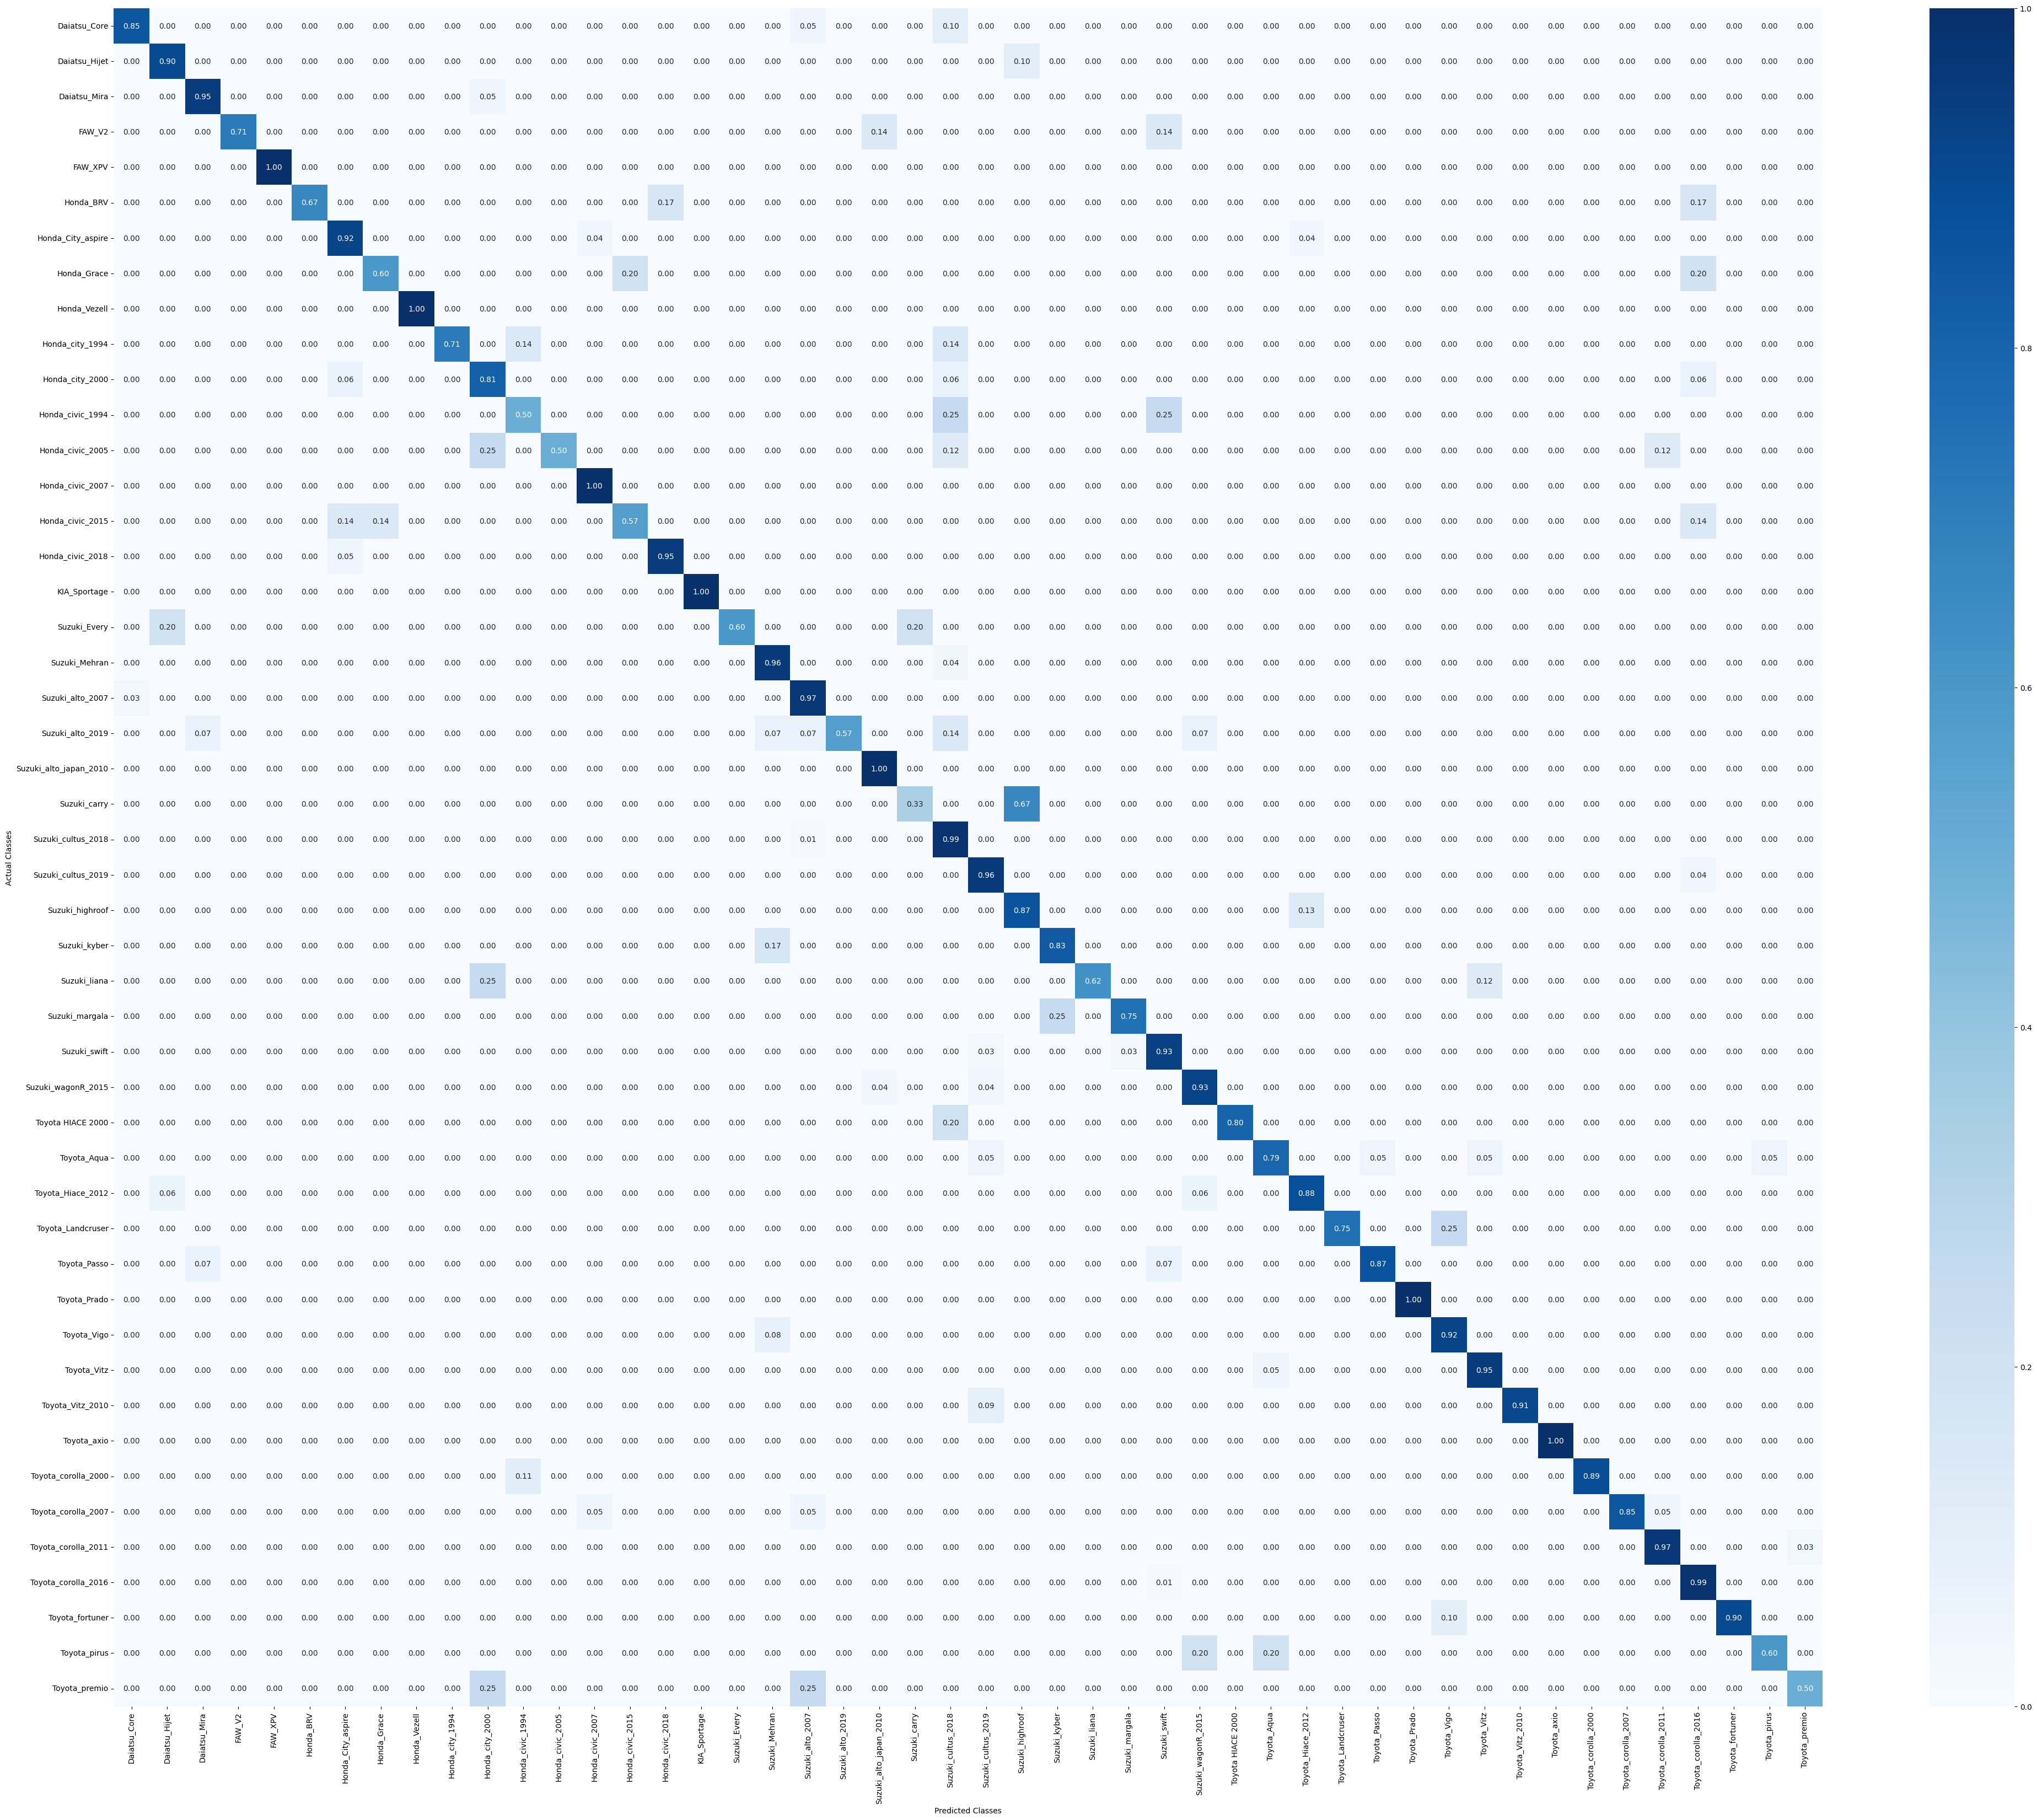

Confusion Matrix:
[[17  0  0 ...  0  0  0]
 [ 0  9  0 ...  0  0  0]
 [ 0  0 19 ...  0  0  0]
 ...
 [ 0  0  0 ...  9  0  0]
 [ 0  0  0 ...  0  3  0]
 [ 0  0  0 ...  0  0  2]]


In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have the ground truth labels for the test data in a variable called 'true_labels'
true_labels = test_generator.classes

# Generate predictions for the test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Define class labels (replace with your actual class names)
labels = train_class_names  # Replace with your class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
fig, ax = plt.subplots(figsize=(50, 40))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap=plt.cm.Blues)
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')

output_file = 'ConfusionMatrix_Xception_SpilitedDataset_SelfAtt.png'  
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

# Generate the classification report
report = classification_report(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)


In [44]:
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.82      0.90      0.86        10
           2       0.90      0.95      0.93        20
           3       1.00      0.71      0.83         7
           4       1.00      1.00      1.00         6
           5       1.00      0.67      0.80         6
           6       0.89      0.92      0.91        26
           7       0.75      0.60      0.67         5
           8       1.00      1.00      1.00         9
           9       1.00      0.71      0.83         7
          10       0.68      0.81      0.74        16
          11       0.50      0.50      0.50         4
          12       1.00      0.50      0.67         8
          13       0.90      1.00      0.95        18
          14       0.80      0.57      0.67         7
          15       0.95      0.95      0.95        20
          16       1.00      1.00      1.00         6
    

In [45]:
from keras.models import load_model
model3.save('BaseInceptionResNetV2.h5')

import IPython
IPython.display.FileLink('BaseInceptionResNetV2.h5')

/kaggle/working/BaseInceptionResNetV2.h5

In [46]:
#waf start
from sklearn.metrics import accuracy_score
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
m1 = load_model('/kaggle/working/DenseNet201+SelfAtten_miobd.h5')
m1 = Model(inputs=m1.inputs, outputs=m1.outputs, name='name_of_model_1')
m2 = load_model('/kaggle/working/resnet152+SelfAtten_SplitedDataset.h5')
m2 = Model(inputs=m2.inputs, outputs=m2.outputs, name='name_of_model_2')
m3 = load_model('/kaggle/working/BaseInceptionResNetV2.h5')
m3 = Model(inputs=m3.inputs, outputs=m3.outputs, name='name_of_model_3')
models = [m1,m2,m3]


In [47]:
models = [m1,m2,m3]
model_input = tf.keras.Input(shape=(224,224,3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)


In [48]:
    
ensemble_model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy', metrics=['accuracy','mse'])

checkpoint = ModelCheckpoint('avgensemble.h5',
                             monitor='val_accuracy', save_best_only=True, save_best_weights=True, 
                             mode='max', verbose=2)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=5, mode='max', verbose=2)

reduce_learning_rate=ReduceLROnPlateau(monitor="val_accuracy",
                                       factor=0.1, patience=5, verbose=2)
    

In [ ]:
history = ensemble_model.fit(train_generator, epochs=epochs, validation_data=test_generator, 
                  callbacks= [checkpoint, early_stop, reduce_learning_rate])

Epoch 1/30


2023-12-14 14:49:29.535858: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/name_of_model_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


97/97 [==============================] - ETA: 0s - loss: 36.8615 - accuracy: 0.9528 - mse: 0.0038
Epoch 1: val_accuracy improved from -inf to 0.89348, saving model to avgensemble.h5
97/97 [==============================] - 367s 1s/step - loss: 36.8615 - accuracy: 0.9528 - mse: 0.0038 - val_loss: 36.3523 - val_accuracy: 0.8935 - val_mse: 0.0053 - lr: 1.0000e-05
Epoch 2/30
97/97 [==============================] - ETA: 0s - loss: 35.4767 - accuracy: 0.9483 - mse: 0.0036
Epoch 2: val_accuracy did not improve from 0.89348
97/97 [==============================] - 98s 1s/step - loss: 35.4767 - accuracy: 0.9483 - mse: 0.0036 - val_loss: 34.9848 - val_accuracy: 0.8881 - val_mse: 0.0050 - lr: 1.0000e-05
Epoch 3/30
97/97 [==============================] - ETA: 0s - loss: 34.1446 - accuracy: 0.9570 - mse: 0.0033
Epoch 3: val_accuracy improved from 0.89348 to 0.90146, saving model to avgensemble.h5
97/97 [==============================] - 105s 1s/step - loss: 34.1446 - accuracy: 0.9570 - mse: 0.003

In [ ]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, w3, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        
    def call(self,inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1] + self.w3 * inputs[2]
        

In [ ]:
ensemble_output = WeightedAverageLayer(0.6, 0.3, 0.1)(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
ensemble_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy','mse'])

checkpoint = ModelCheckpoint('wafensemble.h5',
                             monitor='val_accuracy', save_best_only=True, save_best_weights=True, 
                             mode='max', verbose=2)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=5, mode='max', verbose=2)

reduce_learning_rate=ReduceLROnPlateau(monitor="val_accuracy",
                                       factor=0.1, patience=5, verbose=2)
    

In [ ]:
history = ensemble_model.fit(train_generator, epochs=epochs, validation_data=test_generator, 
                  callbacks= [checkpoint, early_stop, reduce_learning_rate])